In [3]:
import sys
import os
import glob
sys.path.append('../../..')

from model import processing
price_list = processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Nov 1 2022', days=90)
# price_list += [price_list[0]] * 100
print(price_list[0:10])

[{'DOT': 6.62, 'ETH': 1572.69, 'BTC': 20490.74, 'DOGE': 0.12685}, {'DOT': 6.63, 'ETH': 1572.69, 'BTC': 20491.49, 'DOGE': 0.12684}, {'DOT': 6.62, 'ETH': 1573.54, 'BTC': 20493.67, 'DOGE': 0.12714}, {'DOT': 6.62, 'ETH': 1573.09, 'BTC': 20490.01, 'DOGE': 0.12679}, {'DOT': 6.62, 'ETH': 1571.2, 'BTC': 20475.95, 'DOGE': 0.1262}, {'DOT': 6.62, 'ETH': 1571.44, 'BTC': 20474.28, 'DOGE': 0.12611}, {'DOT': 6.62, 'ETH': 1570.52, 'BTC': 20466.76, 'DOGE': 0.12578}, {'DOT': 6.61, 'ETH': 1570.53, 'BTC': 20466.56, 'DOGE': 0.12568}, {'DOT': 6.62, 'ETH': 1570.46, 'BTC': 20466.56, 'DOGE': 0.12579}, {'DOT': 6.62, 'ETH': 1570.24, 'BTC': 20464.07, 'DOGE': 0.12587}]


In [5]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, price, usd_price, dynamicadd_asset_fee, dynamicadd_lrna_fee, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20},
    'DOGE': {'usd price': price_list[0]['DOGE'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            # oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
            lrna_fee=0,
            asset_fee=0,
        )
    },
    agents = {
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'ETH': 1000000000, 'BTC': 3000000000, 'DOGE': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
            trade_strategy=price_sensitive_trading(
                pool_id='omnipool', max_volume_usd=150, price_sensitivity=20
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all = False
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')

test_results = []

def pass_along(min_value, max_value, steps, current):
    return min_value + min(max_value - min_value, 1) * current ** 2 / (steps - 1 or 1) ** 2

trade_volume=10
for fee in [pass_along(0.0, 0.01, 20, i) for i in range(20)]:
    random.seed(42)
    test_state = initial_state.copy()
    test_state.pools['omnipool'].lrna_fee = fee
    test_state.pools['omnipool'].asset_fee = fee * 5
    # test_state.agents['Trader'].trade_strategy += extra_trade_volume('omnipool', percent_of_arb=50, percent_of_pool=1 / initial_omnipool_tvl * trade_volume )
    events = run.run(test_state, time_steps=time_steps)
    # print(events[-1])
    LP_returns = cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market)
    total_volume=[
        sum(events[i].pools['omnipool'].volume_in.values()) + sum(events[i].pools['omnipool'].volume_out.values()) 
        for i in range(len(events))
    ]
    test_results.append((trade_volume, fee, LP_returns, total_volume))
    print(f'lrna fee = {fee}, asset fee = {fee * 5}, trade volume = {sum(total_volume)}')
    print(f'returns = {LP_returns}')
    
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 647587 time steps
Starting simulation...
Execution time: 85.567 seconds.
lrna fee = 0.0, asset fee = 0.0, trade volume = 742860666.0791553
returns = 1010047.4466825066
Starting simulation...
Execution time: 91.47 seconds.
lrna fee = 2.770083102493075e-05, asset fee = 0.00013850415512465375, trade volume = 737011456.1812105
returns = 1010630.1351380346
Starting simulation...
Execution time: 90.716 seconds.
lrna fee = 0.000110803324099723, asset fee = 0.000554016620498615, trade volume = 717785796.2971456
returns = 1012311.0673817792
Starting simulation...
Execution time: 102.27 seconds.
lrna fee = 0.0002493074792243767, asset fee = 0.0012465373961218834, trade volume = 680316502.333865
returns = 1014851.053548542
Starting simulation...
Execution time: 83.886 seconds.
lrna fee = 0.000443213296398892, asset fee = 0.00221606648199446, trade volume = 613306711.5180957
returns = 1017671.8298429467
Starting simulation...
Execution time: 79.906 seconds.
lrna fee = 0.00069252077562

In [6]:
# lines = []
# with open('./output/test_results_static_fees_dec.txt', 'r') as file:
#     data = file.readlines()
#     lines = [float(line [10: 20]) for line in list(filter(lambda line: line[0] == 'r', data))]
    
# print(len(lines))
# print(lines)
# test_results = [lines[i * 10: i * 10 + 10] for i in range(10)]

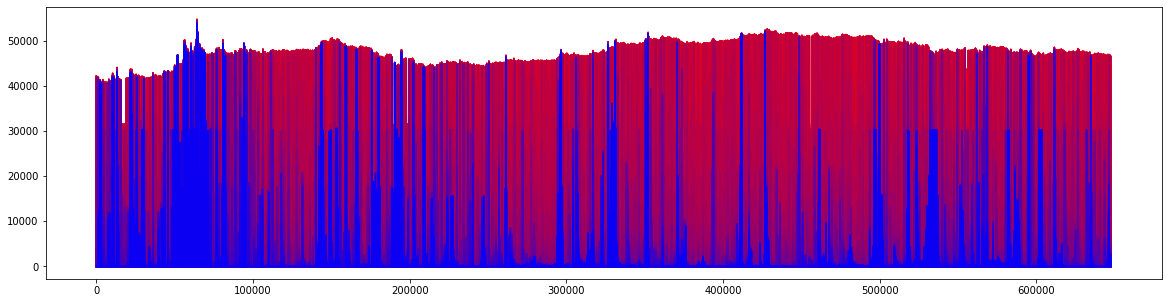

In [7]:
plt.figure(figsize=(20, 5))
colors = pu.color_gradient(len(test_results))
for i, result in enumerate(test_results):
    plt.plot(range(len(result[3])), result[3], color=colors[i])

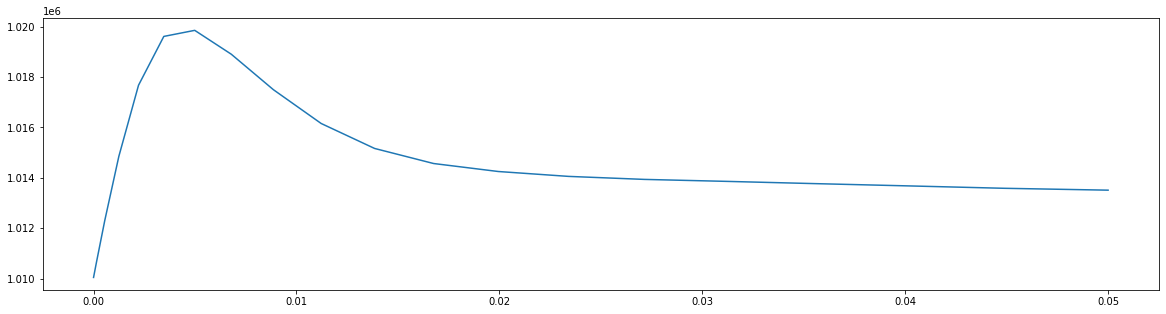

In [8]:
# colors = pu.color_gradient(25)
plt.figure(figsize=(20, 5))
plt.plot([result[1] * 5 for result in test_results], [result[2] for result in test_results])

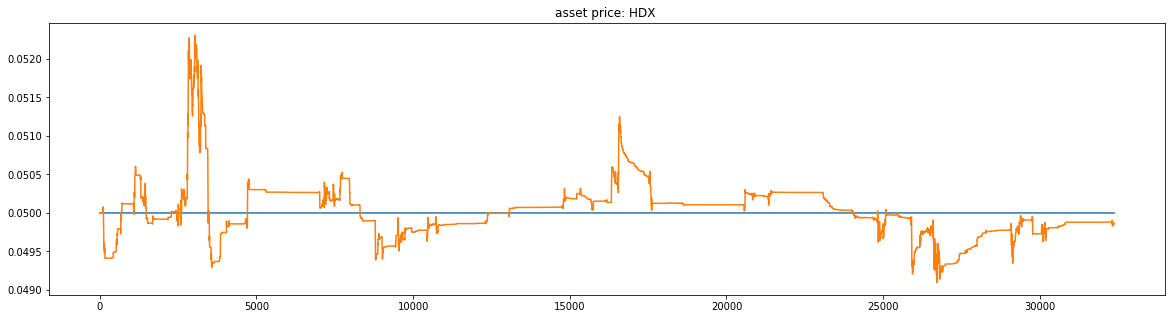

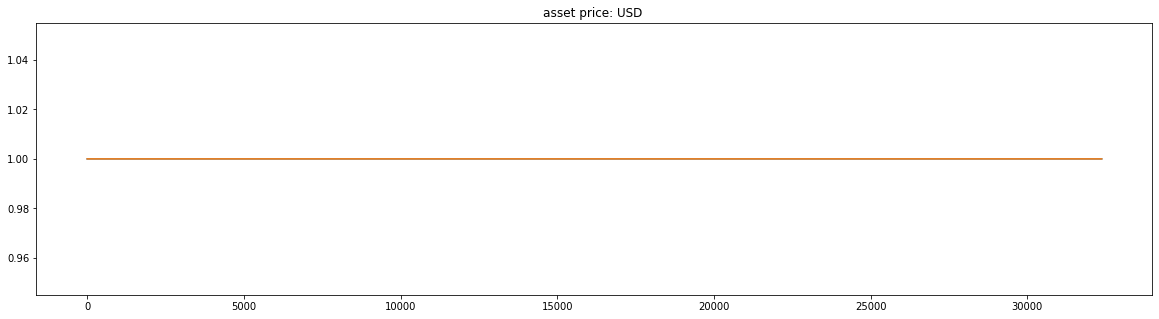

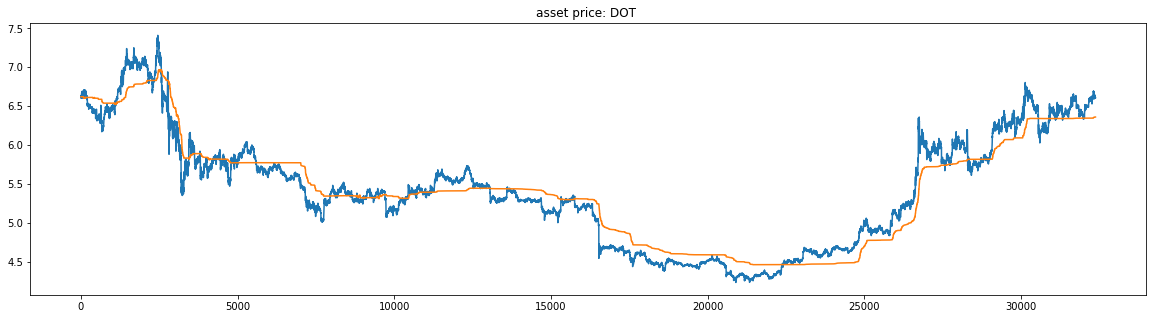

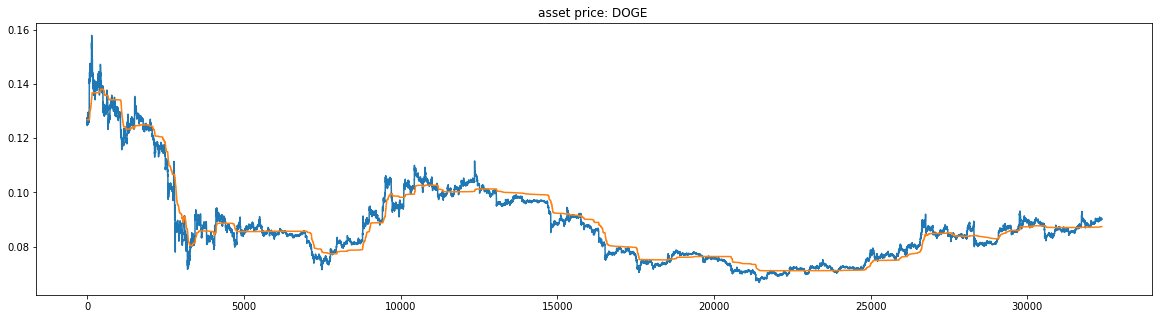

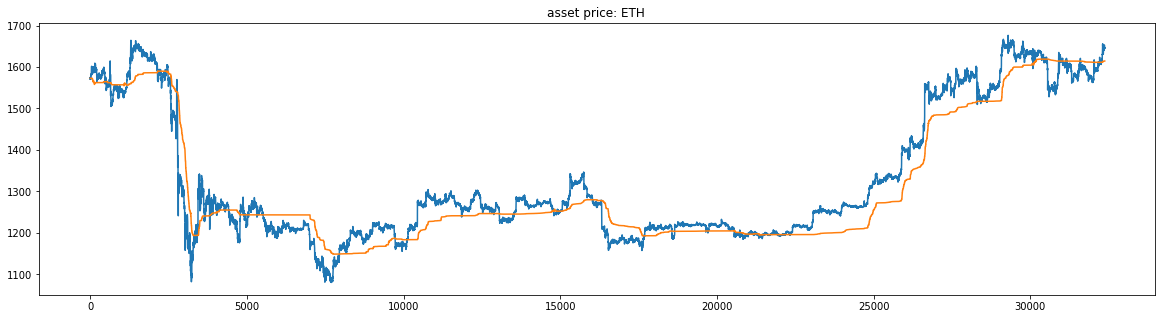

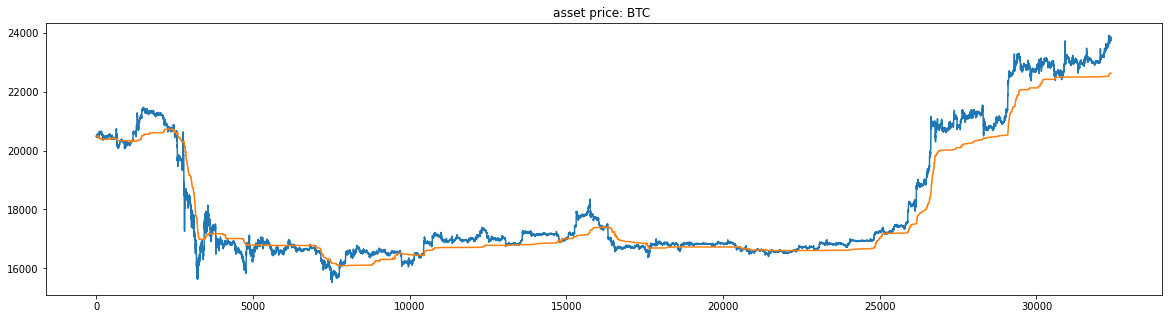

In [9]:
for tkn in initial_state.pools['omnipool'].asset_list:
    ax=pu.plot(events[::20], asset=tkn)
    pu.plot(events[::20], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)

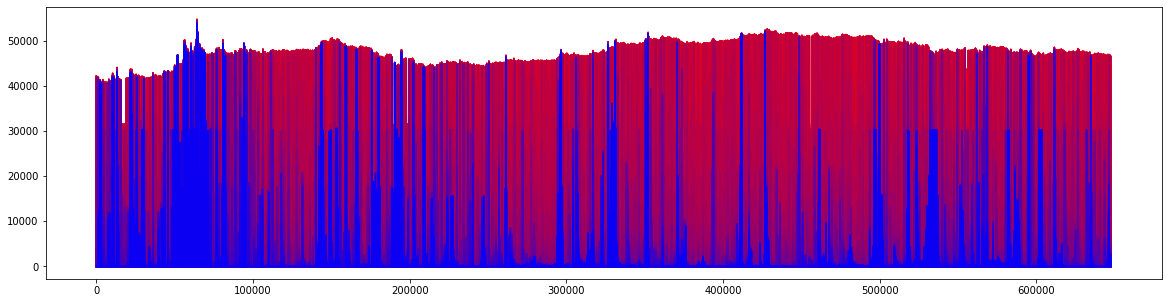

In [10]:
plt.figure(figsize=(20, 5))
colors = pu.color_gradient(len(test_results))
for i, result in enumerate(test_results):
    plt.plot(range(len(result[3])), result[3], color=colors[i])

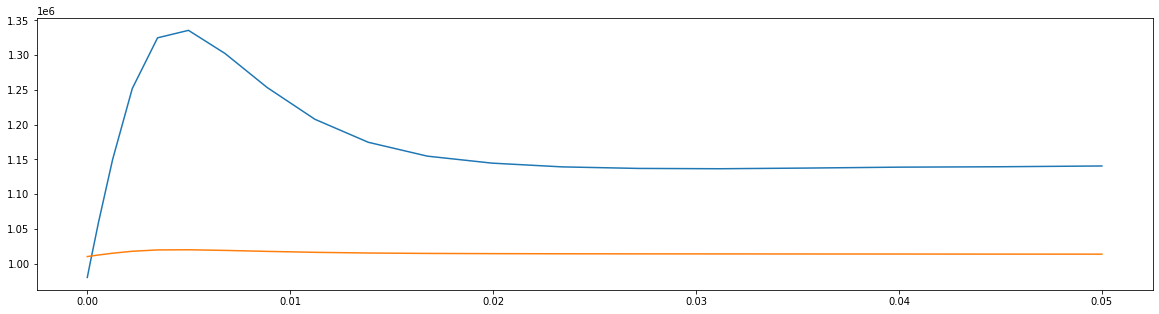

In [11]:
plt.figure(figsize=(20, 5))
plt.plot([result[1] * 5 for result in test_results], [result[1] * sum(result[3]) + 980000  for result in test_results])
# plt.figure(figsize=(20,5))
plt.plot([result[1] * 5 for result in test_results], [result[2] for result in test_results])

In [12]:
import copy
ordered_results = copy.copy(test_results)
ordered_results.sort(key=lambda x: x[2])
pprint([result[:3] for result in ordered_results])

[(10, 0.0, 1010047.4466825066),
 (10, 2.770083102493075e-05, 1010630.1351380346),
 (10, 0.000110803324099723, 1012311.0673817792),
 (10, 0.01, 1013509.8275684803),
 (10, 0.008975069252077562, 1013584.3501143088),
 (10, 0.008005540166204986, 1013681.868589105),
 (10, 0.007091412742382272, 1013771.3840787713),
 (10, 0.006232686980609419, 1013859.344805633),
 (10, 0.005429362880886426, 1013936.8408143792),
 (10, 0.004681440443213296, 1014056.44735962),
 (10, 0.003988919667590027, 1014250.2104941444),
 (10, 0.0033518005540166206, 1014566.9998776263),
 (10, 0.0002493074792243767, 1014851.053548542),
 (10, 0.002770083102493075, 1015164.7551340719),
 (10, 0.0022437673130193906, 1016154.5445549287),
 (10, 0.001772853185595568, 1017495.360871265),
 (10, 0.000443213296398892, 1017671.8298429467),
 (10, 0.0013573407202216066, 1018903.4967399108),
 (10, 0.0006925207756232687, 1019609.1779716469),
 (10, 0.0009972299168975068, 1019849.7085123608)]


In [13]:
basic_state = initial_state.copy()
best_fee = 0.0005
basic_state.pools['omnipool'].asset_fee=best_fee * 5
basic_state.pools['omnipool'].lrna_fee=best_fee

# print(best_fee)
# print(basic_state.agents)
# print(basic_state.pools['omnipool'])

In [14]:
basic_events = run.run(basic_state, time_steps=time_steps)

Starting simulation...
Execution time: 61.589 seconds.


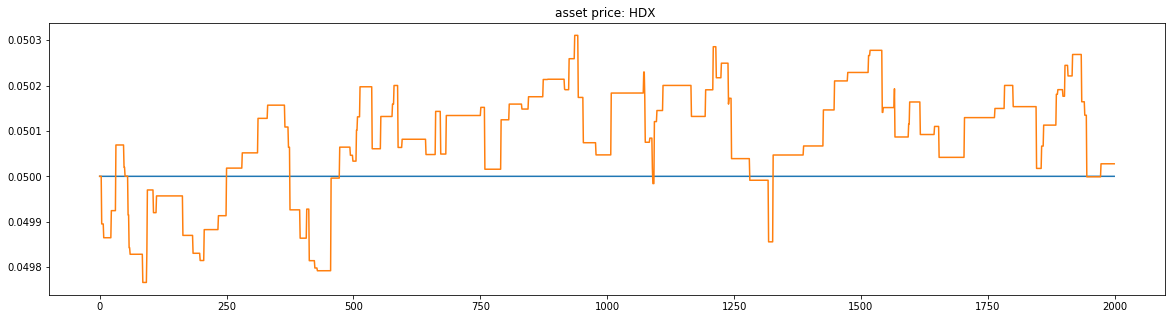

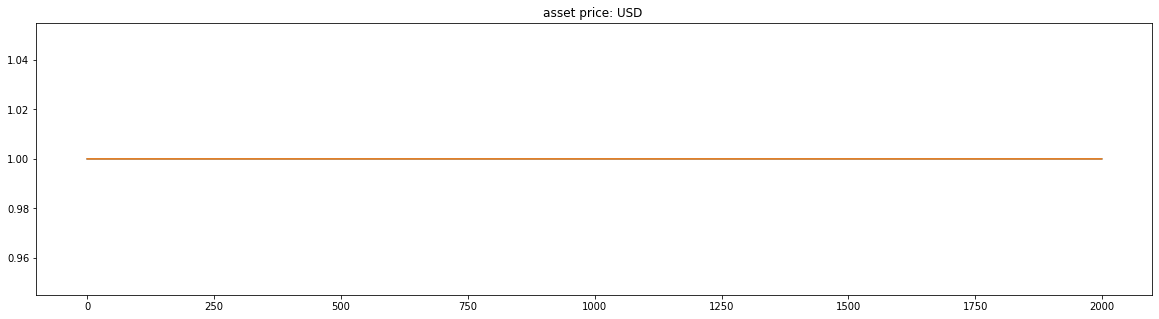

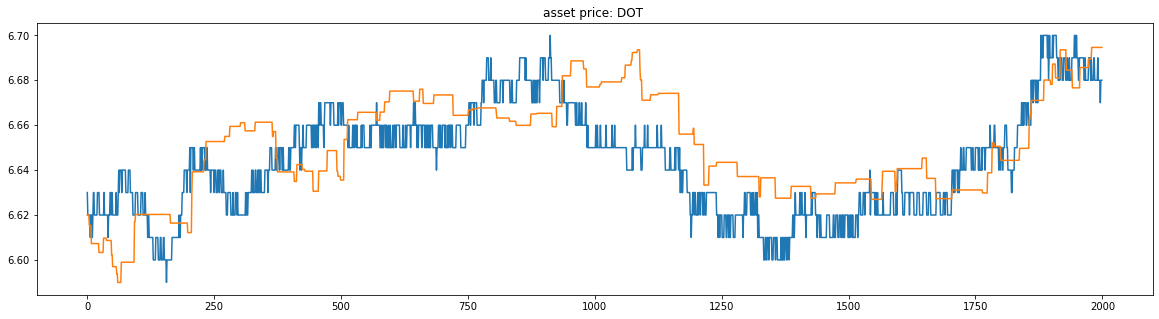

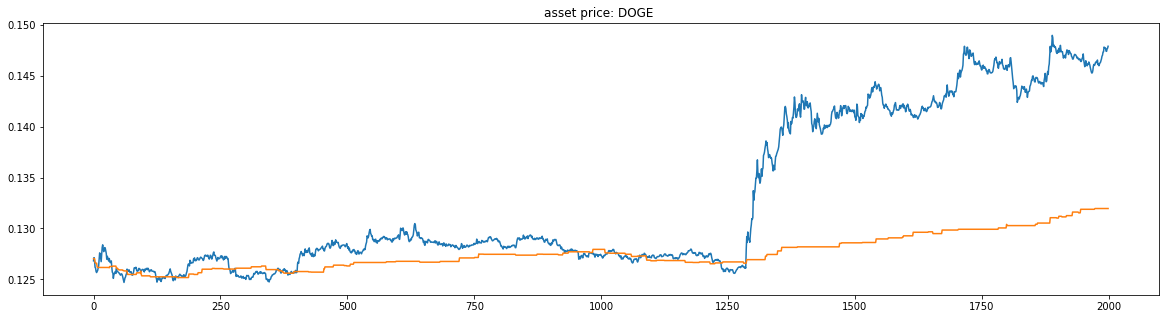

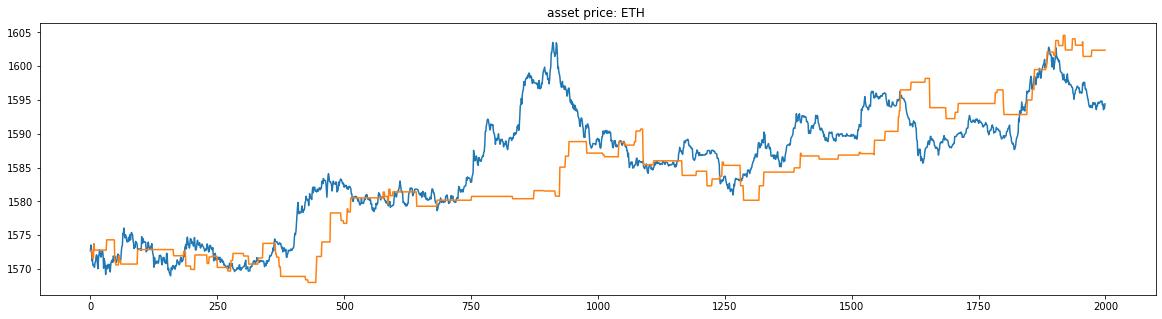

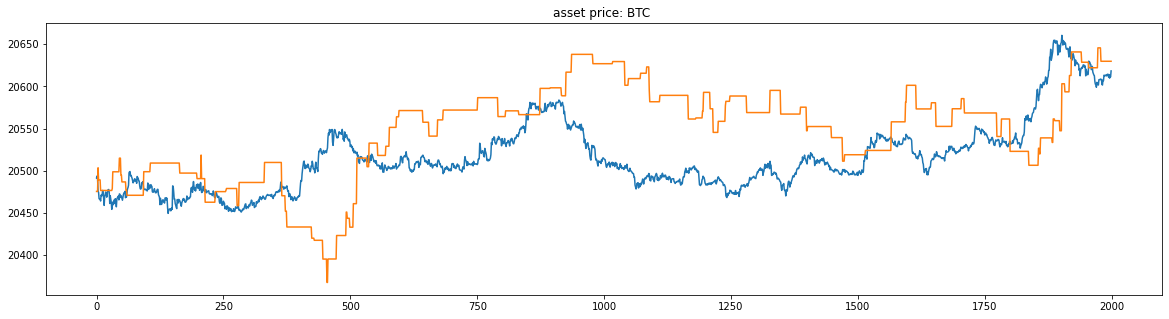

In [15]:
for tkn in basic_events[0].pools['omnipool'].asset_list:
    ax=pu.plot(basic_events[:2000], asset=tkn)
    pu.plot(basic_events[:2000], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)

0.0005
1018327.6121453827


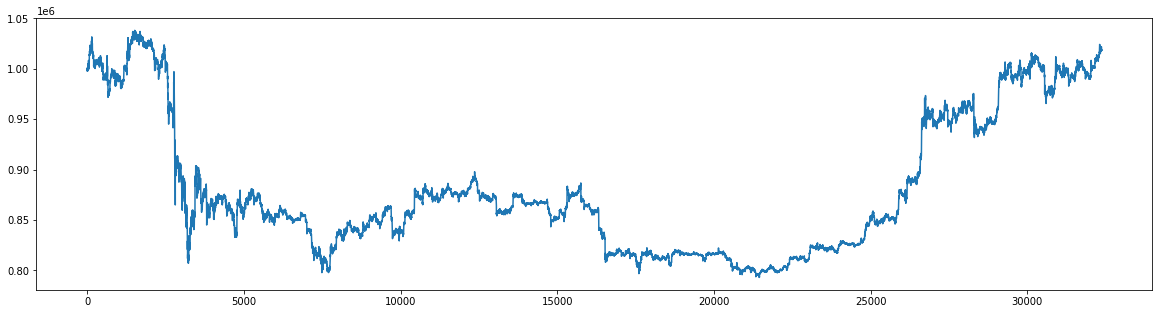

In [16]:
plt.figure(figsize=(20, 5))
LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in basic_events[::20]]


plt.plot(range(len(LP_holdings)), LP_holdings)
print(best_fee)
LP_returns = cash_out_omnipool(basic_events[-1].pools['omnipool'], basic_events[-1].agents['LP'], basic_events[-1].external_market)
print(LP_returns)

In [17]:
print(initial_state.agents['Trader'])

Agent: Trader
********************************
trade strategy: price sensitive trading (sensitivity =20)
holdings: (

    *HDX*: 1000000000

    *USD*: 1000000000

    *ETH*: 1000000000

    *BTC*: 3000000000

    *DOGE*: 3000000000

    *DOT*: 1000000000

    *LRNA*: 1000000000
)

